In [42]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
import cartopy.crs  as ccrs
import os
import datetime
from datetime import timedelta
from datetime import datetime
from matplotlib import ticker
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import geopandas as gp
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
from scipy import stats
from scipy.stats import linregress
import matplotlib.patches as patches
from tqdm import tqdm

import WetBulb

GeoAxes._pcolormesh_patched = Axes.pcolormesh

In [43]:
def remove_time_mean(x):
    return x - x.mean(dim='time')

def standardize(x):
    return x/x.std(dim = 'time')

def CtoF(x):
    return x*9/5 + 32

# Load November 18th data

In [44]:
# Temperature
temp_anom_nov18 = xr.open_dataset('/dx01/ivanov/data/ERA5/Brazil_Heatwave/temp_anom_nov18.nc')
temp_mag_nov18 = xr.open_dataset('/dx01/ivanov/data/ERA5/Brazil_Heatwave/temp_mag_nov18.nc')

In [45]:
# Specific humidity
q_anom_nov18 = xr.open_dataset('/dx01/ivanov/data/ERA5/Brazil_Heatwave/q_anom_nov18.nc')
q_mag_nov18 = xr.open_dataset('/dx01/ivanov/data/ERA5/Brazil_Heatwave/q_mag_nov18.nc')

In [46]:
# Geopotential height
z500_anom_nov18 = xr.open_dataset('/dx01/ivanov/data/ERA5/Brazil_Heatwave/z500_anom_nov18.nc')
z500_mag_nov18 = xr.open_dataset('/dx01/ivanov/data/ERA5/Brazil_Heatwave/z500_mag_nov18.nc')

In [47]:
# Surface wind
uwind_anom_nov18 = xr.open_dataset('/dx01/ivanov/data/ERA5/Brazil_Heatwave/uwind_anom_nov18.nc')
uwind_mag_nov18 = xr.open_dataset('/dx01/ivanov/data/ERA5/Brazil_Heatwave/uwind_mag_nov18.nc')

vwind_anom_nov18 = xr.open_dataset('/dx01/ivanov/data/ERA5/Brazil_Heatwave/vwind_anom_nov18.nc')
vwind_mag_nov18 = xr.open_dataset('/dx01/ivanov/data/ERA5/Brazil_Heatwave/vwind_mag_nov18.nc')

In [48]:
# SSTs
SSTs = xr.open_dataset('/dx01/data/OISST/raw/oisst-avhrr-v02r01.20231118.nc')
SSTs_reg = SSTs.sel(lat = slice(-37,8), lon = slice(-75+360, -32+360)).mean(dim = ['time','zlev'])

In [49]:
# Precipitation
precip_anom_nov18 = xr.open_dataset('/dx01/ivanov/data/ERA5/Brazil_Heatwave/precip_anom_nov18.nc')
precip_mag_surrounding = xr.open_dataset('/dx01/ivanov/data/ERA5/Brazil_Heatwave/precip_mag_surroundingnov18.nc')

In [50]:
# Soil Moisture
SM_anom_nov18 = xr.open_dataset('/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/SM_anom_nov18.nc')
SM_mag_nov18 = xr.open_dataset('/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/SM_mag_nov18.nc')

# Set up colormaps

In [51]:
from matplotlib.colors import LinearSegmentedColormap

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """
    Truncate a colormap to a specific range of values.
    """
    new_cmap = LinearSegmentedColormap.from_list(
        'truncated', cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [52]:
# Choose a diverging colormap
diverging_cmap = plt.get_cmap('coolwarm')

# Define the range of values to truncate
min_value = 0.5  # Minimum value to keep
max_value = 1.0  # Maximum value to keep

# Truncate the colormap
truncated_cmap = truncate_colormap(diverging_cmap, min_value, max_value)

new_cmap = LinearSegmentedColormap.from_list('truncated', diverging_cmap(np.linspace(min_value, max_value, 100)))

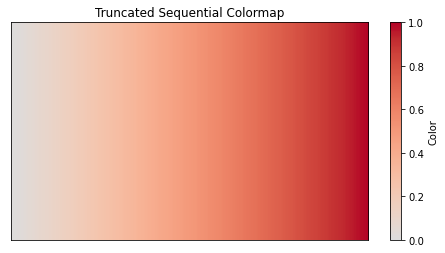

In [53]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

plt.figure(figsize=(8, 4))
plt.imshow(gradient, aspect='auto', cmap=new_cmap)
plt.xticks([])
plt.yticks([])
plt.title('Truncated Sequential Colormap')
plt.colorbar(orientation='vertical', label='Color')
plt.show()

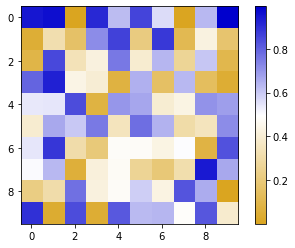

In [54]:
# Make divergent colormap for precipitation
small_color = 'goldenrod'
large_color = 'mediumblue'

precip_anom_cmap = LinearSegmentedColormap.from_list('mycmap', [small_color, 'white', large_color])

fig, ax = plt.subplots()
im = ax.imshow(np.random.random((10, 10)), cmap=precip_anom_cmap, interpolation='nearest')
fig.colorbar(im)
plt.show()

In [55]:
# Define the range of values to truncate
min_value = 0.5
max_value = 1.0

# Truncate the colormap
temp_cmap = truncate_colormap(plt.get_cmap('coolwarm'), min_value, max_value)
SM_cmap = truncate_colormap(plt.get_cmap('PuOr'), min_value, max_value)
q_cmap = truncate_colormap(plt.get_cmap('BrBG'), min_value, max_value)
precip_cmap = truncate_colormap(precip_anom_cmap, min_value, max_value)
SST_cmap = truncate_colormap(plt.get_cmap('RdYlBu_r'), min_value, max_value)

# Figure 3

/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1459: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = self._pcolormesh_patched(*args, **kwargs)
/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)
/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is depr

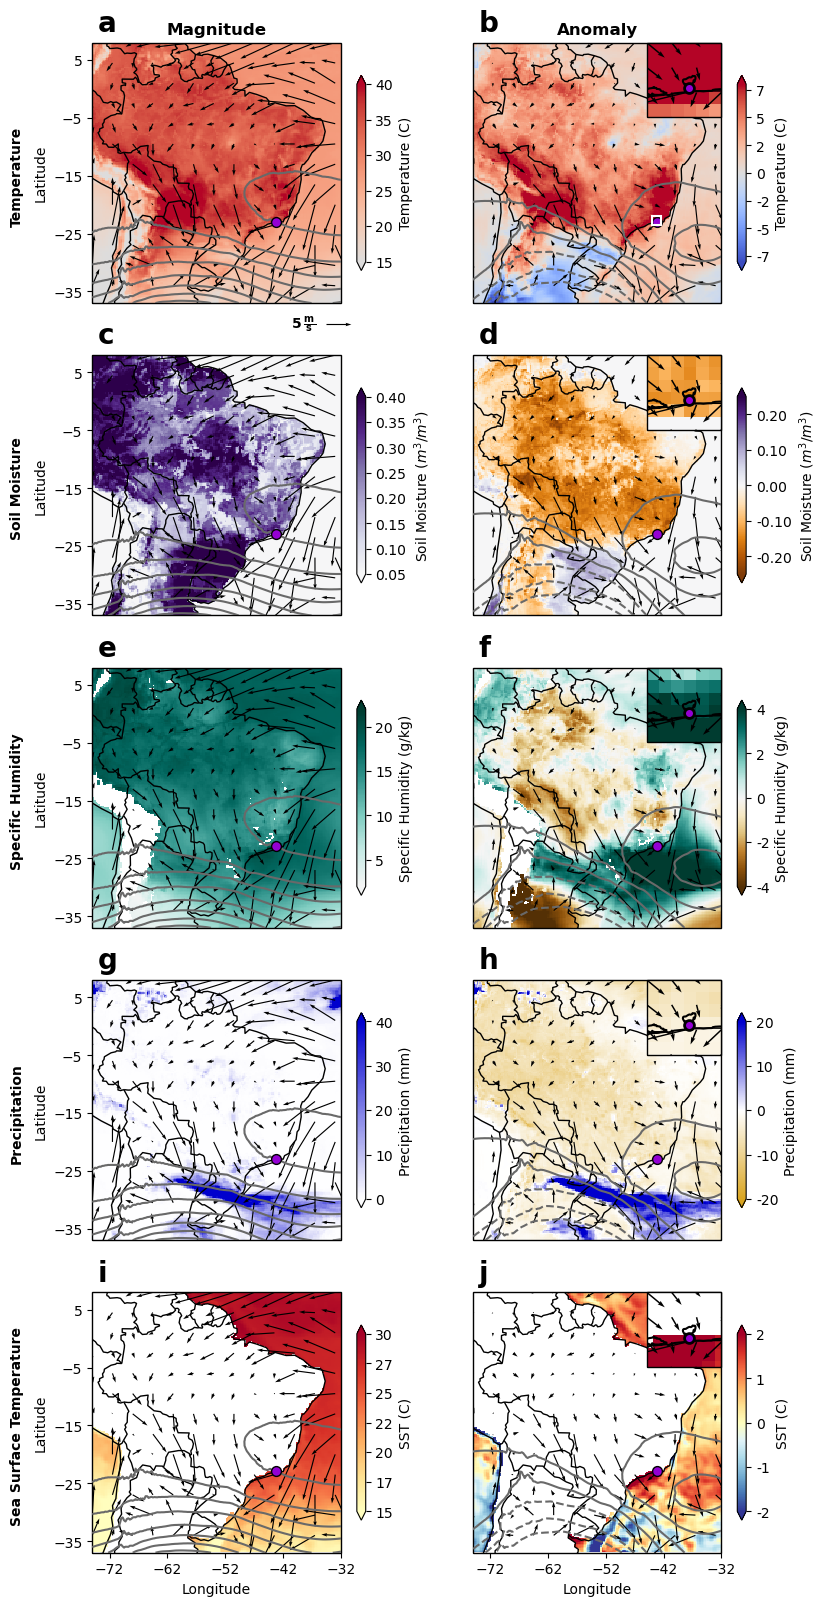

In [56]:
import string

g = 9.80665
lons = [-43.16]
lats = [-22.91]

primary_data = [temp_mag_nov18.t2m.transpose() - 273.15,temp_anom_nov18.t2m.transpose(),SM_mag_nov18.swvl1, SM_anom_nov18.swvl1,1000*q_mag_nov18.q,1000*q_anom_nov18.q,1000*precip_mag_surrounding.isel(time = 5).tp, 1000*precip_anom_nov18.tp,SSTs_reg.sst, SSTs_reg.anom]
labels = ['Temperature (C)','Temperature (C)','Soil Moisture ($m^{3}/m^{3}$)','Soil Moisture ($m^{3}/m^{3}$)','Specific Humidity (g/kg)', 'Specific Humidity (g/kg)', 'Precipitation (mm)','Precipitation (mm)', 'SST (C)', 'SST (C)']
primary_mins = [15,-8,0.05,-0.25,2,-4,0,-20,15,-2]
primary_maxs = [40,8,0.40,0.25, 22,4,40,20,30,2]
#cmaps = ['Reds','coolwarm','Oranges','PuOr','BuGn','BrBG','Greens','PiYG','YlOrRd','RdYlBu_r']
cmaps = [temp_cmap,'coolwarm',SM_cmap,'PuOr',q_cmap,'BrBG',precip_cmap,precip_anom_cmap,SST_cmap,'RdYlBu_r']
titles = ['Temperature','Temperature','Soil Moisture','Soil Moisture','Specific Humidity','Specific Humidity','Precipitation','Precipitation','Sea Surface Temperature','Sea Surface Temperature']
cont_color = 'dimgrey'
secondary_data = [uwind_mag_nov18.u10,uwind_anom_nov18.u10,vwind_mag_nov18.v10,vwind_anom_nov18.v10,z500_mag_nov18.z, z500_anom_nov18.z]

# For inset
left, bottom, width, height = [0.75, 0.85, 0.1, 0.1]
n_inset = 2
skip_inset = (slice(None, None, n_inset), slice(None, None, n_inset))

n = 14

fig, axs = plt.subplots(5,2, figsize = (9,20),facecolor = 'w', edgecolor = 'k', subplot_kw = {'projection': ccrs.PlateCarree()}, dpi = 100)

for i, ax in enumerate(fig.axes):
    
    back_data = primary_data[i]
    cmap = cmaps[i]
    
    if i < 8:
        mesh = ax.pcolormesh(back_data.longitude, back_data.latitude, back_data, vmin = primary_mins[i], vmax = primary_maxs[i], cmap = cmaps[i])
    
    if i >= 8:
        mesh = ax.pcolormesh(back_data.lon, back_data.lat, back_data, vmin = primary_mins[i], vmax = primary_maxs[i], cmap = cmaps[i])

    if i in [2,3]:
        fmt = '%.2f'
    else:
        fmt = '%1d'
    
    cbar = plt.colorbar(mesh, ax = ax, shrink = 0.75, format = fmt, label = labels[i], fraction = 0.05, pad = 0.05, extend = 'both')

    ax.coastlines(linewidth=1)
    ax.add_feature(cfeature.BORDERS)
    
    ax.set_xlim([-75,-32])
    ax.set_ylim([-37,8])
        
    if (i % 2) == 0:

        # Add wind magnitude on top
        skip = (slice(None, None, n), slice(None, None, n))
        u_sub = secondary_data[0][skip]
        v_sub = secondary_data[2][skip]

        quiv = ax.quiver(secondary_data[0].longitude[::n], secondary_data[0].latitude[::n], u_sub, v_sub, scale = 50)
        ax.set_ylabel('Latitude')
        ax.set_yticks([-35,-25,-15,-5,5]);
        
        # Add z500 contours on top
        levels = np.arange(-5550,6000,50)
        contour = ax.contour(secondary_data[4].longitude, secondary_data[4].latitude, secondary_data[4]/g, levels = levels, colors = cont_color, zorder = 3)
        
        # Add title to left of plot
        ax.text(-88,-15, titles[i], fontweight = 'bold', rotation = 90, horizontalalignment = 'center',verticalalignment = 'center')
        
    if (i % 2) != 0:
        
        # Add wind anomalies on top
        skip = (slice(None, None, n), slice(None, None, n))
        u_sub = secondary_data[1][skip]
        v_sub = secondary_data[3][skip]

        quiv = ax.quiver(secondary_data[1].longitude[::n], secondary_data[1].latitude[::n], u_sub, v_sub, scale = 50)
        
        # Add z500 contours on top
        levels = np.arange(-75,75 + 25,25)
        contour = ax.contour(secondary_data[5].longitude, secondary_data[5].latitude, secondary_data[5]/g, levels = levels, colors= cont_color, zorder = 3)
    
    if i > 7:
        ax.set_xlabel('Longitude')
        ax.set_xticks([-72,-62, -52,-42, -32])
        
    if i == 0:
        ax.set_title('Magnitude', fontweight = 'bold')
        qk = ax.quiverkey(quiv, 0.94, -0.08, 5, r'$\mathbf{5 \: \frac{m}{s}}$',labelpos='W', coordinates='axes', color='k', labelcolor='k', fontproperties = {"weight": 600}, zorder = 100)
        
    if i == 1:
        ax.set_title('Anomaly', fontweight = 'bold')
        
    # INSET
    if (i % 2) != 0:
        
        size = .3 # Figure Standardized coordinates (0~1)

        l, b, w, h = ax.get_position().bounds

        iax = plt.axes([l, b, size*w, size*h], projection=ccrs.PlateCarree(), label='2')
        iax.coastlines()

        extent=[-44,-42.5,-23.5,-22]
        iax.set_extent(extent, crs=ccrs.PlateCarree())

        def set_subplot2corner(ax,ax_sub,corner="bottomright"):
            p1 = ax.get_position()
            p2 = ax_sub.get_position()
            if corner == "topright":
                ax_sub.set_position([p1.x1-p2.width, p1.y1-p2.height, p2.width, p2.height])
            if corner == "bottomright":
                ax_sub.set_position([p1.x1-p2.width, p1.y0, p2.width, p2.height])
            if corner == "bottomleft":
                ax_sub.set_position([p1.x0, p1.y0, p2.width, p2.height])
            if corner == "topleft":
                ax_sub.set_position([p1.x0, p1.y1-p2.height, p2.width, p2.height])

        set_subplot2corner(ax,iax,corner="topright")

        if i < 8:
            mesh = iax.pcolormesh(back_data.longitude, back_data.latitude, back_data, vmin = primary_mins[i], vmax = primary_maxs[i], cmap = cmaps[i])

        if i >= 8:
            mesh = iax.pcolormesh(back_data.lon, back_data.lat, back_data, vmin = primary_mins[i], vmax = primary_maxs[i], cmap = cmaps[i])

        iax.coastlines(linewidth=1.5, resolution = '10m')
        iax.add_feature(cfeature.BORDERS)

        iax.set_xlim([-44,-42.5])
        iax.set_ylim([-23.5,-22])

        lons = [-43.16]
        lats = [-22.91]
        iax.scatter(lons, lats, s = 50, marker = 'o', color = 'darkviolet', edgecolor = 'k', linewidth = 2, zorder = 10)

        u1 = uwind_anom_nov18.u10
        v1 = vwind_anom_nov18.v10

        u_sub = u1[skip_inset]
        v_sub = v1[skip_inset]

        q = iax.quiver(uwind_anom_nov18.longitude[::n_inset], uwind_anom_nov18.latitude[::n_inset], u_sub, v_sub, scale = 7, width = 0.02)
        
        plt.setp(iax.spines.values(), lw=5, color='k');
        
    if i == 1:
        p1 = plt.Rectangle((extent[0],extent[2]), extent[1] - extent[0], extent[3]-extent[2], fill= False, linewidth = 1.5, facecolor = None,edgecolor = 'white', zorder = 100, alpha = 1)
        ax.add_patch(p1)
        
    # Add Rio marker to every plot
    ax.scatter(lons, lats, s = 50, marker = 'o', color = 'darkviolet', edgecolor = 'k', linewidth = 1, zorder = 10)

    # Add label to each subplot
    ax.text(-74, 10, string.ascii_lowercase[i], size=20, weight='bold')
    
#plt.savefig('/home/ivanov/jupyternb/Brazil_Heatwave/Final Figures for Upload/Figure3.png')

plt.show()

# Load composite data

In [57]:
# Temperature
regTanom_during_T99 = xr.open_dataset('/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/regTanom_during_T99.nc')
regT_during_T99 = xr.open_dataset('/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/regT_during_T99.nc')

# Specific humidity
regqanom_during_T99 = xr.open_dataset('/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/regqanom_during_T99.nc')
regq_during_T99 = xr.open_dataset('/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/regq_during_T99.nc')

# Precipitation
regprecipanom_during_T99 = xr.open_dataset('/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/regprecipanom_during_T99.nc')
regprecip_during_T99 = xr.open_dataset('/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/regprecip_during_T99.nc')

# Sea surface temperature
regSSTanom_during_T99 = xr.open_dataset('/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/regSSTanom_during_T99.nc')
regSST_during_T99 = xr.open_dataset('/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/regSST_during_T99.nc')

# Surface winds
reguwindanom_during_T99 = xr.open_dataset('/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/reguwindanom_during_T99.nc')
reguwind_during_T99 = xr.open_dataset('/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/reguwind_during_T99.nc')

regvwindanom_during_T99 = xr.open_dataset('/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/regvwindanom_during_T99.nc')
regvwind_during_T99 = xr.open_dataset('/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/regvwind_during_T99.nc')

# Geopotential height
regz500anom_during_T99 = xr.open_dataset('/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/regz500anom_during_T99.nc')
regz500_during_T99 = xr.open_dataset('/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/regz500_during_T99.nc')

# Soil moisture
regSManom_during_T99 = xr.open_dataset('/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/regSManom_during_T99.nc')
regSM_during_T99 = xr.open_dataset('/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/regSM_during_T99.nc')

# Figure S5

/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1459: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = self._pcolormesh_patched(*args, **kwargs)
/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)
/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is depr

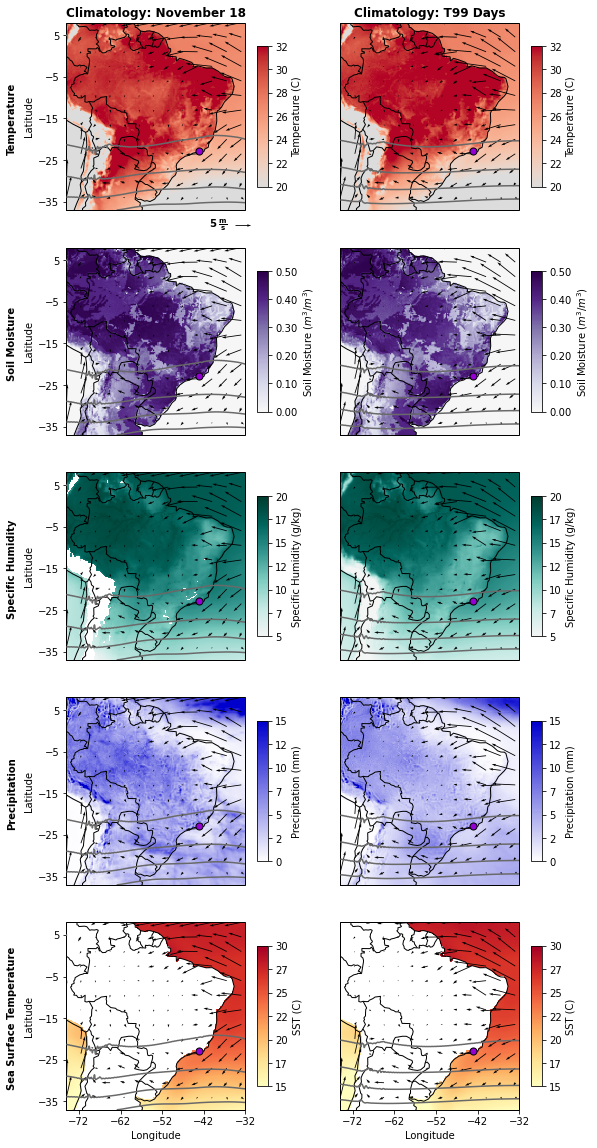

In [21]:
g = 9.80665
primary_data = [temp_mag_nov18.t2m.transpose() - 273.15 - temp_anom_nov18.t2m.transpose(),regT_during_T99.t2m.transpose() - 273.15 - regTanom_during_T99.t2m.transpose(),
                SM_mag_nov18.swvl1 - SM_anom_nov18.swvl1,regSM_during_T99.swvl1 - regSManom_during_T99.swvl1,
                1000*q_mag_nov18.q - 1000*q_anom_nov18.q,1000*regq_during_T99.q - 1000*regqanom_during_T99.q,
                1000*precip_mag_surrounding.isel(time = 5).tp - 1000*precip_anom_nov18.tp,1000*regprecip_during_T99.tp-1000*regprecipanom_during_T99.tp,
                SSTs_reg.sst - SSTs_reg.anom, regSST_during_T99.sst - regSSTanom_during_T99.anom]
labels = ['Temperature (C)','Temperature (C)','Soil Moisture ($m^{3}/m^{3}$)','Soil Moisture ($m^{3}/m^{3}$)','Specific Humidity (g/kg)', 'Specific Humidity (g/kg)', 'Precipitation (mm)','Precipitation (mm)', 'SST (C)', 'SST (C)']
primary_mins = [20,20,0,0,5,5,0,0,15,15]
primary_maxs = [32,32,0.5,0.5, 20,20,15,15,30,30]
cmaps = [temp_cmap,temp_cmap,SM_cmap,SM_cmap,q_cmap,q_cmap,precip_cmap,precip_cmap,SST_cmap,SST_cmap]
titles = ['Temperature','Temperature','Soil Moisture','Soil Moisture','Specific Humidity','Specific Humidity',
          'Precipitation','Precipitation','Sea Surface Temperature','Sea Surface Temperature']
cont_color = 'dimgrey'
secondary_data = [uwind_mag_nov18.u10 - uwind_anom_nov18.u10,reguwind_during_T99.u10 - reguwindanom_during_T99.u10,
                  vwind_mag_nov18.v10 - vwind_anom_nov18.v10,regvwind_during_T99.v10 - regvwindanom_during_T99.v10,
                  z500_mag_nov18.z - z500_anom_nov18.z, regz500_during_T99.z - regz500anom_during_T99.z]

# For inset
left, bottom, width, height = [0.75, 0.85, 0.1, 0.1]
n_inset = 2
skip_inset = (slice(None, None, n_inset), slice(None, None, n_inset))

n = 14

fig, axs = plt.subplots(5,2, figsize = (9,20),facecolor = 'w', edgecolor = 'k',constrained_layout=True, subplot_kw = {'projection': ccrs.PlateCarree()})

for i, ax in enumerate(fig.axes):
    
    back_data = primary_data[i]
    cmap = cmaps[i]
        
    if i < 8:
        mesh = ax.pcolormesh(back_data.longitude, back_data.latitude, back_data, vmin = primary_mins[i], vmax = primary_maxs[i], cmap = cmaps[i])

    if i >= 8:
        mesh = ax.pcolormesh(back_data.lon, back_data.lat, back_data, vmin = primary_mins[i], vmax = primary_maxs[i], cmap = cmaps[i])

    if i in [2,3]:
        fmt = '%.2f'
    else:
        fmt = '%1d'

    ax.coastlines(linewidth=1)
    ax.add_feature(cfeature.BORDERS)

    ax.set_xlim([-75,-32])
    ax.set_ylim([-37,8])

    cbar = plt.colorbar(mesh, ax = ax, shrink = 0.75, format = fmt, label = labels[i], fraction = 0.05, pad = 0.05)
    
    if (i%2) == 0:
        
        # Add wind magnitude on top
        skip = (slice(None, None, n), slice(None, None, n))
        u_sub = secondary_data[0][skip]
        v_sub = secondary_data[2][skip]

        quiv = ax.quiver(secondary_data[0].longitude[::n], secondary_data[0].latitude[::n], u_sub, v_sub)
        ax.set_ylabel('Latitude')
        ax.set_yticks([-35,-25,-15,-5,5]);

        # Add z500 contours on top
        levels = np.arange(-5550,6000,50)
        contour = ax.contour(secondary_data[4].longitude, secondary_data[4].latitude, secondary_data[4]/g, levels = levels, colors = cont_color, zorder = 3)

        # Add title to left of plot
        ax.text(-88,-15, titles[i], fontweight = 'bold', rotation = 90, horizontalalignment = 'center',verticalalignment = 'center')

    if (i%2) != 0:
        
        # Add winds on top
        skip = (slice(None, None, n), slice(None, None, n))
        u_sub = secondary_data[1][skip]
        v_sub = secondary_data[3][skip]

        quiv = ax.quiver(secondary_data[1].longitude[::n], secondary_data[1].latitude[::n], u_sub, v_sub, scale = 50)
        
        # Add z500 contours on top
        levels = np.arange(-5550,6000,50)
        contour = ax.contour(secondary_data[5].longitude, secondary_data[5].latitude, secondary_data[5]/g, levels = levels, colors= cont_color, zorder = 3)
    
    if i > 7:
        ax.set_xlabel('Longitude')
        ax.set_xticks([-72,-62, -52,-42, -32])
        
    if i == 0:
        ax.set_title('Climatology: November 18', fontweight = 'bold')
        qk = ax.quiverkey(quiv, 0.94, -0.08, 5, r'$\mathbf{5 \: \frac{m}{s}}$', labelpos='W', coordinates='axes', color='k', labelcolor='k', fontproperties = {"weight": 600}, zorder = 100)
        box = qk.text.set_backgroundcolor('w')
    
    if i == 1:
        ax.set_title('Climatology: T99 Days', fontweight = 'bold')
    
    # Add Rio marker
    ax.scatter(lons, lats, s = 50, marker = 'o', color = 'darkviolet', edgecolor = 'k', linewidth = 1, zorder = 10)

# Figure 4

In [58]:
primary_data_nov18 = [temp_mag_nov18.t2m.transpose() - 273.15,SM_mag_nov18.swvl1, 1000*q_mag_nov18.q,1000*precip_mag_surrounding.isel(time = 5).tp, SSTs_reg.sst]
primary_data_T99 = [regT_during_T99.t2m.transpose() - 273.15,regSM_during_T99.swvl1, 1000*regq_during_T99.q,1000*regprecip_during_T99.tp, regSST_during_T99.sst]

secondary_data_nov18 = [uwind_mag_nov18.u10,vwind_mag_nov18.v10,z500_mag_nov18.z]
secondary_data_T99 = [reguwind_during_T99.u10,regvwind_during_T99.v10,regz500_during_T99.z]

/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


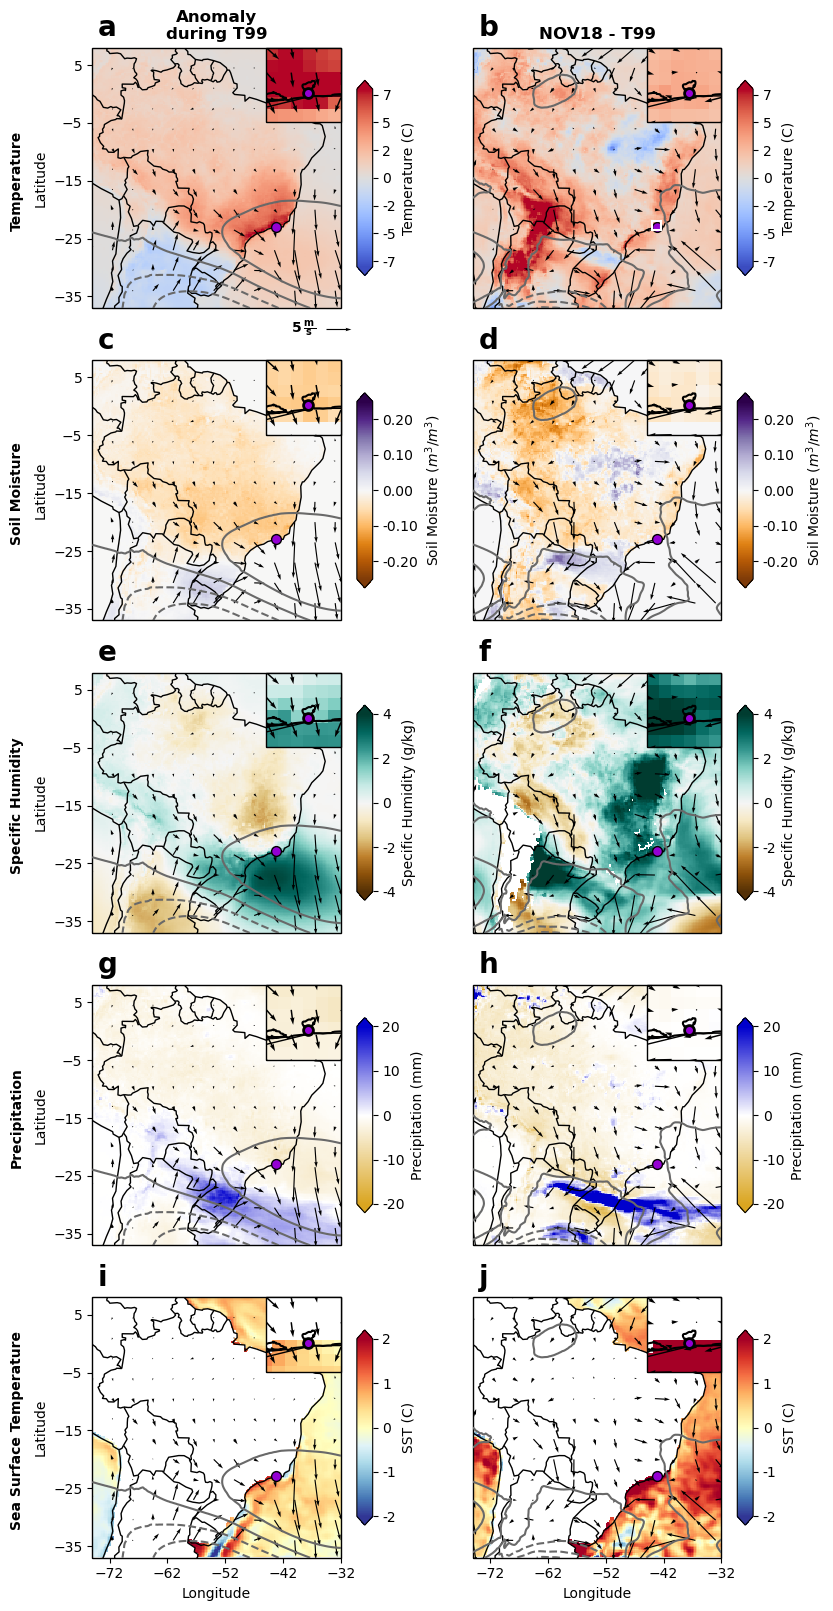

In [59]:
# Plot two column figure with these anomalies
primary_data_T99anom = [regTanom_during_T99.t2m.transpose(), regT_during_T99.t2m.transpose() - 273.15,regSManom_during_T99.swvl1, regSM_during_T99.swvl1, 1000*regqanom_during_T99.q,
                        1000*regq_during_T99.q,1000*regprecipanom_during_T99.tp,1000*regprecip_during_T99.tp, regSSTanom_during_T99.anom, regSST_during_T99.sst]

primary_data_nov18 = [temp_mag_nov18.t2m.transpose() - 273.15,SM_mag_nov18.swvl1, 1000*q_mag_nov18.q,1000*precip_mag_surrounding.isel(time = 5).tp, SSTs_reg.sst]
primary_data_T99 = [regT_during_T99.t2m.transpose() - 273.15,regSM_during_T99.swvl1, 1000*regq_during_T99.q,1000*regprecip_during_T99.tp, regSST_during_T99.sst]

secondary_data_nov18 = [uwind_mag_nov18.u10,vwind_mag_nov18.v10,z500_mag_nov18.z]
secondary_data_T99 = [reguwind_during_T99.u10,regvwind_during_T99.v10,regz500_during_T99.z]

labels = ['Temperature (C)','Temperature (C)','Soil Moisture ($m^{3}/m^{3}$)','Soil Moisture ($m^{3}/m^{3}$)','Specific Humidity (g/kg)', 'Specific Humidity (g/kg)', 'Precipitation (mm)','Precipitation (mm)', 'SST (C)', 'SST (C)']
primary_mins = [-8,-8,-0.25,-0.25,-4,-4,-20,-20,-2,-2]
primary_maxs = [8,8,0.25,0.25, 4,4,20,20,2,2]
cmaps = ['coolwarm','coolwarm','PuOr','PuOr','BrBG','BrBG',precip_anom_cmap,precip_anom_cmap,'RdYlBu_r','RdYlBu_r']
titles = ['Temperature','Temperature','Soil Moisture','Soil Moisture','Specific Humidity','Specific Humidity','Precipitation','Precipitation','Sea Surface Temperature','Sea Surface Temperature']
cont_color = 'dimgrey'

secondary_data_T99anom = [reguwindanom_during_T99.u10,reguwind_during_T99.u10,regvwindanom_during_T99.v10,regvwind_during_T99.v10,
                          regz500anom_during_T99.z, regz500_during_T99.z]

# For inset
left, bottom, width, height = [0.75, 0.85, 0.1, 0.1]
n_inset = 2
skip_inset = (slice(None, None, n_inset), slice(None, None, n_inset))

n = 14

g = 9.80665

fig, axs = plt.subplots(5,2, figsize = (9,20),facecolor = 'w', edgecolor = 'k',constrained_layout=True, subplot_kw = {'projection': ccrs.PlateCarree()}, dpi = 100)

for i, ax in enumerate(fig.axes):

    if i % 2 == 0:
        back_data = primary_data_T99anom[i]
        uwind = secondary_data_T99anom[0]
        vwind = secondary_data_T99anom[2]
        z500 = secondary_data_T99anom[4]
        ax.set_ylabel('Latitude')
        ax.set_yticks([-35,-25,-15,-5,5]);
        ax.text(-88,-15, titles[i], fontweight = 'bold', rotation = 90, horizontalalignment = 'center',verticalalignment = 'center')

    else:
        back_data = primary_data_nov18[int((i-1)/2)] - primary_data_T99[int((i-1)/2)]
        uwind = secondary_data_nov18[0] - secondary_data_T99[0]
        vwind = secondary_data_nov18[1] - secondary_data_T99[1]
        z500 = secondary_data_nov18[2] - secondary_data_T99[2]
    
    if i < 8:
        mesh = ax.pcolormesh(back_data.longitude, back_data.latitude, back_data, vmin = primary_mins[i], vmax = primary_maxs[i], cmap = cmaps[i])
    
    if i >= 8:
        mesh = ax.pcolormesh(back_data.lon, back_data.lat, back_data, vmin = primary_mins[i], vmax = primary_maxs[i], cmap = cmaps[i])

    if i in [2,3]:
        fmt = '%.2f'
    else:
        fmt = '%1d'
    
    cbar = plt.colorbar(mesh, ax = ax, shrink = 0.75, format = fmt, label = labels[i], fraction = 0.05, pad = 0.05, extend = 'both')

    ax.coastlines(linewidth=1)
    ax.add_feature(cfeature.BORDERS)
    
    ax.set_xlim([-75,-32])
    ax.set_ylim([-37,8])

    # Add wind difference on top
    skip = (slice(None, None, n), slice(None, None, n))
    u_sub = uwind[skip]
    v_sub = vwind[skip]

    quiv = ax.quiver(uwind.longitude[::n], uwind.latitude[::n], u_sub, v_sub, scale = 50)
    
    # Add z500 contours on top
    levels = np.arange(-75,75 + 25,25)
    contour = ax.contour(z500.longitude, z500.latitude, z500/g, levels = levels, colors= cont_color, zorder = 3)
    
    if i > 7:
        ax.set_xlabel('Longitude')
        ax.set_xticks([-72,-62, -52,-42, -32])
        
    if i == 0:
        ax.set_title('Anomaly\nduring T99', fontweight = 'bold')
        qk = ax.quiverkey(quiv, 0.94, -0.08, 5, r'$\mathbf{5 \: \frac{m}{s}}$',labelpos='W', coordinates='axes', color='k', labelcolor='k', fontproperties = {"weight": 600}, zorder = 100)
        
    if i == 1:
        ax.set_title('NOV18 - T99', fontweight = 'bold')

    # CREATE INSET

    size = .3 # Figure Standardized coordinates (0~1)
    #GeoAxes has a width/height ratio according to self's projection
    #Therefore, Here only set  a same width and height

    l, b, w, h = ax.get_position().bounds

    iax = plt.axes([l, b, size*w, size*h], projection=ccrs.PlateCarree(), label='2')
    iax.coastlines()

    extent=[-44,-42.5,-23.5,-22]
    iax.set_extent(extent, crs=ccrs.PlateCarree())

    def set_subplot2corner(ax,ax_sub,corner="bottomright"):
        p1 = ax.get_position()
        p2 = ax_sub.get_position()
        if corner == "topright":
            ax_sub.set_position([p1.x1-p2.width, p1.y1-p2.height, p2.width, p2.height])
        if corner == "bottomright":
            ax_sub.set_position([p1.x1-p2.width, p1.y0, p2.width, p2.height])
        if corner == "bottomleft":
            ax_sub.set_position([p1.x0, p1.y0, p2.width, p2.height])
        if corner == "topleft":
            ax_sub.set_position([p1.x0, p1.y1-p2.height, p2.width, p2.height])

    set_subplot2corner(ax,iax,corner="topright")

    if i < 8:
        mesh = iax.pcolormesh(back_data.longitude, back_data.latitude, back_data, vmin = primary_mins[i], vmax = primary_maxs[i], cmap = cmaps[i])

    if i >= 8:
        mesh = iax.pcolormesh(back_data.lon, back_data.lat, back_data, vmin = primary_mins[i], vmax = primary_maxs[i], cmap = cmaps[i])

    iax.coastlines(linewidth=1.5, resolution = '10m')
    iax.add_feature(cfeature.BORDERS)

    iax.set_xlim([-44,-42.5])
    iax.set_ylim([-23.5,-22])

    lons = [-43.16]
    lats = [-22.91]
    iax.scatter(lons, lats, s = 50, marker = 'o', color = 'darkviolet', edgecolor = 'k', linewidth = 2, zorder = 10)

    u1 = uwind
    v1 = vwind

    u_sub = u1[skip_inset]
    v_sub = v1[skip_inset]

    q = iax.quiver(uwind.longitude[::n_inset], uwind.latitude[::n_inset], u_sub, v_sub, scale = 7, width = 0.02)
    
    plt.setp(iax.spines.values(), lw=5, color='k');
        
    if i == 1:
        p1 = plt.Rectangle((extent[0],extent[2]), extent[1] - extent[0], extent[3]-extent[2], fill= False, linewidth = 1.5, facecolor = None,edgecolor = 'white', zorder = 100, alpha = 1)
        ax.add_patch(p1)
        
    # Add Rio marker to every plot
    ax.scatter(lons, lats, s = 50, marker = 'o', color = 'darkviolet', edgecolor = 'k', linewidth = 1, zorder = 10)

    # Add label to each subplot
    ax.text(-74, 10, string.ascii_lowercase[i], size=20, weight='bold')

#plt.savefig('/home/ivanov/jupyternb/Brazil_Heatwave/Final Figures for Upload/Figure4.png')

plt.show()

# Figure 2

In [60]:
stn_folder = '/dx01/ivanov/data/HadISD_stationdata/brazil_heatwave/raw_station_data/'

# Rio stations
galeao_name = 'hadisd.3.4.0.2023f_19310101-20240101_837460-99999.nc'
campo_name = 'hadisd.3.4.0.2023f_19310101-20240101_837480-99999.nc'
santos_name = 'hadisd.3.4.0.2023f_19310101-20240101_837550-99999.nc'

galeao = xr.open_dataset(stn_folder + galeao_name)
campo = xr.open_dataset(stn_folder + campo_name)
santos = xr.open_dataset(stn_folder + santos_name)

In [61]:
stn_folder = '/dx01/ivanov/data/HadISD_stationdata/brazil_heatwave/raw_station_data/'

galeao_temp = galeao.temperatures.where(galeao.temperatures > -2*np.exp(30))
galeao_Tmax = galeao_temp.resample(time="1D").max(dim='time')

campo_temp = campo.temperatures.where(campo.temperatures > -2*np.exp(30))
campo_Tmax = campo_temp.resample(time="1D").max(dim='time')

santos_temp = santos.temperatures.where(santos.temperatures > -2*np.exp(30))
santos_Tmax = santos_temp.resample(time="1D").max(dim='time')

stn_Tmax = galeao_Tmax.sel(time = slice('01-01-1972','12-31-2023'))

# Calculate station level anomaly and climatology for all november 18ths
stn_anomalies = stn_Tmax.groupby('time.dayofyear').apply(remove_time_mean)
stn_anom = stn_anomalies.sel(time = '2023-11-18').values

stn_mag = stn_Tmax.sel(time = '2023-11-18').values
stn_clim = stn_mag - stn_anom

/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1459: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = self._pcolormesh_patched(*args, **kwargs)
/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is depr

10.67450980392157
11.859574468085107
5.663265306122447


/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


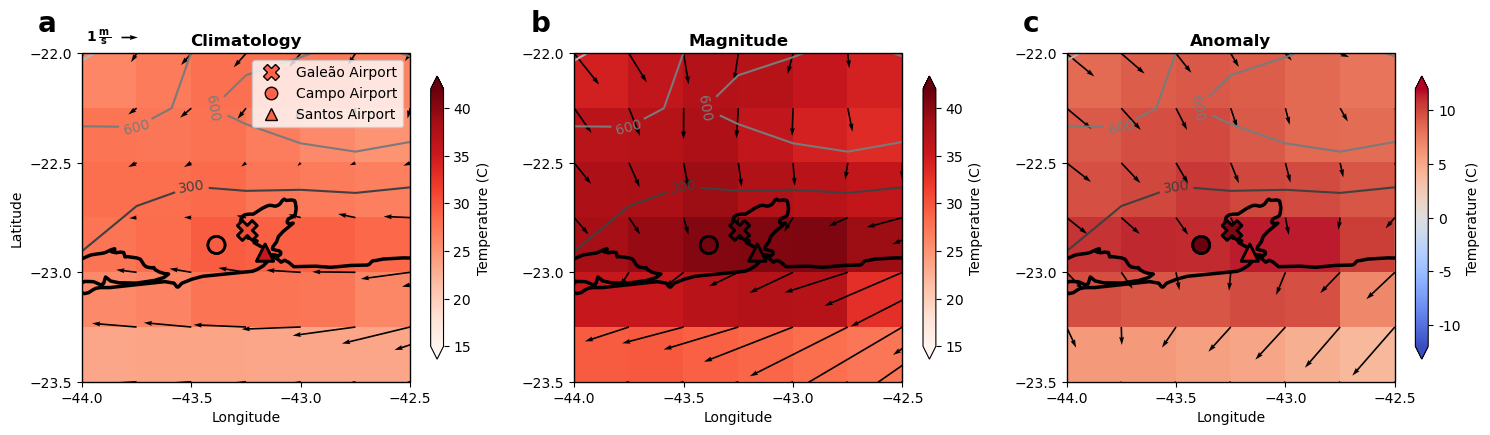

In [62]:
import string

######## CLIMATOLOGY
fig, axs = plt.subplots(1,3,figsize = (18,5), facecolor = 'w', edgecolor = 'k', subplot_kw = {'projection': ccrs.PlateCarree()}, dpi = 100)

mesh = axs[0].pcolormesh(temp_mag_nov18.longitude, temp_mag_nov18.latitude, temp_mag_nov18['t2m'].transpose() -273.15 - temp_anom_nov18['t2m'].transpose(), vmin = 15, vmax = 42, cmap = 'Reds')
cbar1 = plt.colorbar(mesh, ax = axs[0], shrink = 0.75, format = '%1d', label = 'Temperature (C)', pad = 0.05, extend = 'both')
axs[0].set_ylabel('Latitude')
axs[0].set_xlabel('Longitude')
axs[0].set_title('Climatology', fontweight = 'bold')

axs[0].coastlines(linewidth=2.5, resolution='10m')
axs[0].add_feature(cfeature.BORDERS)

axs[0].set_xlim([-44,-42.5])
axs[0].set_ylim([-23.5,-22])
axs[0].set_xticks([-44,-43.5,-43,-42.5])
axs[0].set_yticks([-23.5,-23,-22.5,-22])
axs[0].set_ylabel('Latitude')
axs[0].set_xlabel('Longitude')

# Add elevation contours
sfc_geo = xr.open_dataset('/dx01/data/ERA5/time_invariant/geopotential.nc')
elevation = sfc_geo.z/9.80665

# Generate mask
file = '/dx01/data/ERA5/time_invariant/land_sea_mask.nc'
sftlf_ref = xr.open_dataset(file).mean(dim = "time")

elev_land = elevation.where(sftlf_ref >= 0.5, drop=True).mean(dim= 'time').sel(latitude = slice(-22,-23.5), longitude = slice(-44 +360,-42.5 +360))
elev_levels = np.linspace(0,1500,6)

elev_cont = axs[0].contour(elev_land.longitude, elev_land.latitude, elev_land.lsm, cmap = 'Greys_r', levels = elev_levels)
axs[0].clabel(elev_cont, elev_cont.levels, fmt = '%1d', fontsize=10)

n = 1
skip = (slice(None, None, n), slice(None, None, n))

u1 = uwind_mag_nov18.u10 - uwind_anom_nov18.u10
v1 = vwind_mag_nov18.v10 - vwind_anom_nov18.v10

u_sub = u1[skip]
v_sub = v1[skip]

q = axs[0].quiver(uwind_anom_nov18.longitude[::n], uwind_anom_nov18.latitude[::n], u_sub, v_sub, scale = 20, width = 0.005)
qk = axs[0].quiverkey(q, 0.12, 1.05, 1, label = r'$\mathbf{1 \: \frac{m}{s}}$',labelpos='W', coordinates='axes', color='k', labelcolor='k', fontproperties = {"weight": 600})

axs[0].text(-44.2, -21.9, string.ascii_lowercase[0], size=20, weight='bold')


####### MAGNITUDE
mesh = axs[1].pcolormesh(temp_mag_nov18.longitude, temp_mag_nov18.latitude, temp_mag_nov18['t2m'].transpose() -273.15, vmin = 15, vmax = 42, cmap = 'Reds')
cbar1 = plt.colorbar(mesh, ax = axs[1], shrink = 0.75, format = '%1d', label = 'Temperature (C)', pad = 0.05, extend = 'both')
axs[1].set_ylabel('Latitude')
axs[1].set_xlabel('Longitude')
axs[1].set_title('Magnitude', fontweight = 'bold')

axs[1].coastlines(linewidth=2.5, resolution='10m')
axs[1].add_feature(cfeature.BORDERS)

axs[1].set_xlim([-44,-42.5])
axs[1].set_ylim([-23.5,-22])
axs[1].set_xticks([-44,-43.5,-43,-42.5])
axs[1].set_yticks([-23.5,-23,-22.5,-22])
axs[1].set_ylabel(' ')
axs[1].set_xlabel('Longitude')

elev_cont = axs[1].contour(elev_land.longitude, elev_land.latitude, elev_land.lsm, cmap = 'Greys_r', levels = elev_levels)
axs[1].clabel(elev_cont, elev_cont.levels, fmt = '%1d', fontsize=10)

n = 1
skip = (slice(None, None, n), slice(None, None, n))

u1 = uwind_mag_nov18.u10
v1 = vwind_mag_nov18.v10

u_sub = u1[skip]
v_sub = v1[skip]

q = axs[1].quiver(uwind_mag_nov18.longitude[::n], uwind_mag_nov18.latitude[::n], u_sub, v_sub, scale = 20, width = 0.005)
axs[1].text(-44.2, -21.9, string.ascii_lowercase[1], size=20, weight='bold')

####### ANOMALIES
mesh = axs[2].pcolormesh(temp_anom_nov18.longitude, temp_anom_nov18.latitude, temp_anom_nov18['t2m'].transpose(), vmin = -12, vmax = 12, cmap = 'coolwarm')
cbar1 = plt.colorbar(mesh, shrink = 0.75, ax = axs[2], format = '%1d', label = 'Temperature (C)', pad = 0.05, extend = 'both')
axs[2].set_ylabel('Latitude')
axs[2].set_xlabel('Longitude')
axs[2].add_feature(cfeature.BORDERS)
axs[2].set_title('Anomaly', fontweight = 'bold')

axs[2].coastlines(linewidth=2.5, resolution='10m')
axs[2].add_feature(cfeature.BORDERS)

axs[2].set_xlim([-44,-42.5])
axs[2].set_ylim([-23.5,-22])
axs[2].set_xticks([-44,-43.5,-43,-42.5])
axs[2].set_yticks([-23.5,-23,-22.5,-22])
axs[2].set_ylabel(' ')
axs[2].set_xlabel('Longitude')

elev_cont = axs[2].contour(elev_land.longitude, elev_land.latitude, elev_land.lsm, cmap = 'Greys_r', levels = elev_levels)
axs[2].clabel(elev_cont, elev_cont.levels, fmt = '%1d', fontsize=10)

n = 1
skip = (slice(None, None, n), slice(None, None, n))

u1 = uwind_anom_nov18.u10
v1 = vwind_anom_nov18.v10

u_sub = u1[skip]
v_sub = v1[skip]

q = axs[2].quiver(uwind_anom_nov18.longitude[::n], uwind_anom_nov18.latitude[::n], u_sub, v_sub, scale = 20, width = 0.005)
axs[2].text(-44.2, -21.9, string.ascii_lowercase[2], size=20, weight='bold')
# Plot station data on top
galeao_lons = [galeao.longitude.values,galeao.longitude.values]
galeao_lats = [galeao.latitude.values,galeao.latitude.values]

campo_lons = [campo.longitude.values,campo.longitude.values]
campo_lats = [campo.latitude.values,campo.latitude.values]

santos_lons = [santos.longitude.values,santos.longitude.values]
santos_lats = [santos.latitude.values,santos.latitude.values]

station_Tmaxs = [galeao_Tmax, campo_Tmax, santos_Tmax]

station_names = ['Galeão Airport','Campo Airport','Santos Airport']

station_lons = [galeao_lons,campo_lons,santos_lons]
station_lats = [galeao_lats,campo_lats,santos_lats]
            
for i, station_Tmax_temp in enumerate(station_Tmaxs):

    lons = station_lons[i]
    lats = station_lats[i]
    
    station_Tmax = station_Tmax_temp.sel(time = slice('01-01-1972','12-31-2023'))
    
    # Calculate station level anomaly and climatology for all november 18ths
    stn_anomalies = station_Tmax.groupby('time.dayofyear').apply(remove_time_mean)
    stn_anom = stn_anomalies.sel(time = '2023-11-18').values
    
    print(stn_anom)
    
    stn_mag = stn_Tmax.sel(time = '2023-11-18').values
    stn_clim = stn_mag - stn_anom

    if i == 0:
        marker = 'X'
        size = 200
    elif i == 1:
        marker = 'o'
        size = 150
    else:
        marker = '^'
        size = 150

    axs[0].scatter(lons, lats, s = size, c = [stn_clim,stn_clim], edgecolor = 'k', marker = marker, linewidth = 2, cmap = 'Reds', vmin = 15, vmax = 42, zorder = 10, label = station_names[i])
    axs[1].scatter(lons, lats, s = size, c = [stn_mag,stn_mag], edgecolor = 'k', marker = marker,linewidth = 2, cmap = 'Reds', vmin = 15, vmax = 42,zorder = 10, label = station_names[i])
    axs[2].scatter(lons, lats, s = size, c = [stn_anom,stn_anom], edgecolor = 'k', marker = marker, linewidth = 2, cmap = 'Reds', vmin = -12, vmax = 12 ,zorder = 10, label = station_names[i]) 

import matplotlib.lines as mlines

cross = mlines.Line2D([0], [0], label=station_names[0], markersize = 11, marker='X', markeredgecolor='k', markerfacecolor='tomato', linestyle='')
circle = mlines.Line2D([0], [0], label=station_names[1], markersize = 9,marker='o', markeredgecolor='k', markerfacecolor='tomato', linestyle='')
triangle = mlines.Line2D([0], [0], label=station_names[2], markersize = 9,marker='^', markeredgecolor='k', markerfacecolor='tomato', linestyle='')

# etc etc
axs[0].legend(handles=[cross, circle,triangle], loc = 'upper right')

#plt.savefig('Figure2.png')

# Figure S1

In [63]:
# Load new station data
file_dir = '/home/ivanov/jupyternb/Brazil_Heatwave/'
file_names = ['alto_da_boa_vista_202311_Met.txt','guaratiba_202311_Met.txt','iraja_202311_Met.txt',
              'jardim_botanico_202311_Met.txt','riocentro_202311_Met.txt','santa_cruz_202311_Met.txt',
             'sao_cristovao_202311_Met.txt','vidigal_202311_Met.txt']

stations = pd.read_csv(file_dir + 'station_data.csv')
stn_nov = pd.read_excel(file_dir + 'november/' + 'station_november_data.xls',0)

In [64]:
vidigal = pd.read_excel(file_dir + 'november/station_november_data.xls',0)
sao_cristovao = pd.read_excel(file_dir + 'november/station_november_data.xls',1)
santa_cruz = pd.read_excel(file_dir + 'november/station_november_data.xls',2)
riocentro = pd.read_excel(file_dir + 'november/station_november_data.xls',3)
jardim_botanico = pd.read_excel(file_dir + 'november/station_november_data.xls',4)
iraja = pd.read_excel(file_dir + 'november/station_november_data.xls',5)
guaratiba = pd.read_excel(file_dir + 'november/station_november_data.xls',6)
alto_da_boa_vista = pd.read_excel(file_dir + 'november/station_november_data.xls',7)

In [65]:
# Combine all temperature columns across stations
vidigal_temp = vidigal[['Dia', 'Temperatura (celsius)']].copy()
all_stn_nov = vidigal_temp.rename(columns = {'Temperatura (celsius)':'vidigal'})

all_stn_nov['sao_cristovao'] = sao_cristovao['Temperatura (celsius)']
all_stn_nov['santa_cruz'] = santa_cruz['Temperatura (celsius)']
all_stn_nov['riocentro'] = riocentro['Temperatura (celsius)']
all_stn_nov['jardim_botanico'] = jardim_botanico['Temperatura (celsius)']
all_stn_nov['iraja'] = iraja['Temperatura (celsius)']
all_stn_nov['guaratiba'] = guaratiba['Temperatura (celsius)']
all_stn_nov['alto_da_boa_vista'] = alto_da_boa_vista['Temperatura (celsius)']

In [66]:
all_stn_nov['Date']= pd.to_datetime(all_stn_nov['Dia'])

In [67]:
nov18 = all_stn_nov[all_stn_nov['Date'] == '2023-11-18']
nov18_data = nov18.drop(columns = ['vidigal','iraja','Dia'])
nov18_data = nov18_data.set_index('Date')

In [68]:
stations = stations.sort_values(by=['Tmax'], ascending = False)

In [69]:
stn_folder = '/dx01/ivanov/data/HadISD_stationdata/brazil_heatwave/raw_station_data/'

# Rio stations
galeao_name = 'hadisd.3.4.0.2023f_19310101-20240101_837460-99999.nc'
campo_name = 'hadisd.3.4.0.2023f_19310101-20240101_837480-99999.nc'
santos_name = 'hadisd.3.4.0.2023f_19310101-20240101_837550-99999.nc'

galeao = xr.open_dataset(stn_folder + galeao_name)
campo = xr.open_dataset(stn_folder + campo_name)
santos = xr.open_dataset(stn_folder + santos_name)

# Change flagged values to nan
galeao_temp = galeao.temperatures.where(galeao.temperatures > -2*np.exp(30))
campo_temp = campo.temperatures.where(campo.temperatures > -2*np.exp(30))
santos_temp = santos.temperatures.where(santos.temperatures > -2*np.exp(30))

In [70]:
galeao_nov18 = galeao_temp.sel(time = '2023-11-18')
campo_nov18 = campo_temp.sel(time = '2023-11-18')
santos_nov18 = santos_temp.sel(time = '2023-11-18')

In [71]:
galeao_max = galeao_nov18.max()
campo_max = campo_nov18.max()
santos_max = santos_nov18.max()

/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1459: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = self._pcolormesh_patched(*args, **kwargs)
/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is depr

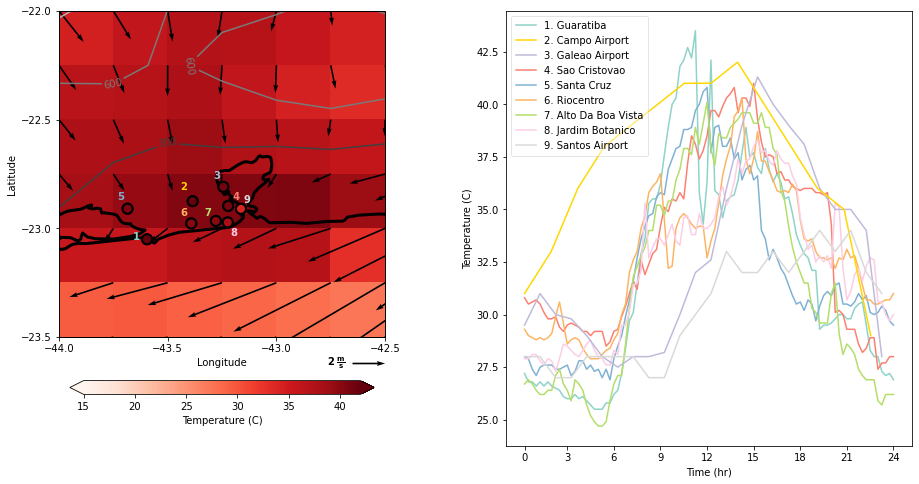

In [72]:
import string

fig = plt.figure(figsize = (16,8))

gs = fig.add_gridspec(1,2)
ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1])

####### MAGNITUDE
mesh = ax1.pcolormesh(temp_mag_nov18.longitude, temp_mag_nov18.latitude, temp_mag_nov18['t2m'].transpose() -273.15, vmin = 15, vmax = 42, cmap = 'Reds')
cbar1 = plt.colorbar(mesh, ax = ax1, shrink = 0.75, format = '%1d', label = 'Temperature (C)', pad = 0.10, orientation = 'horizontal',extend = 'both')

ax1.coastlines(linewidth=3, resolution='10m')
ax1.add_feature(cfeature.BORDERS)

ax1.set_xlim([-44,-42.5])
ax1.set_ylim([-23.5,-22])
ax1.set_xticks([-44,-43.5,-43,-42.5])
ax1.set_yticks([-23.5,-23,-22.5,-22])
ax1.set_ylabel('Latitude')
ax1.set_xlabel('Longitude')

#line_colors = ['#ddcc77','#999933','#117733','#44aa99','#88ccee', '#322288']
line_colors = ['#8dd3c7','gold','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9']

for index, row in stations.iterrows():

    if index > 1:
        
        lons = [row.longitude,row.longitude]
        lats = [row.latitude,row.latitude]
        colors = [row.Tmax,row.Tmax]

        ax1.scatter(lons, lats, s = 100, c = colors, edgecolor = 'k', linewidth = 2, cmap = 'Reds', vmin = 15, vmax = 42,zorder = 10)

        
# Plot three airport stations
airport_stns = [galeao, campo, santos]
airport_maxes = [galeao_max, campo_max, santos_max]

for i in range(3):
    
    lons = [np.squeeze(airport_stns[i].longitude.values),np.squeeze(airport_stns[i].longitude.values)]
    lats = [np.squeeze(airport_stns[i].latitude.values),np.squeeze(airport_stns[i].latitude.values)]
    colors = [np.squeeze(airport_maxes[i].values),np.squeeze(airport_maxes[i].values)]
    
    ax1.scatter(lons, lats, s = 100, c = colors, edgecolor = 'k', linewidth = 2, cmap = 'Reds', vmin = 15, vmax = 42,zorder = 10)
        
# Add elevation contours
sfc_geo = xr.open_dataset('/dx01/data/ERA5/time_invariant/geopotential.nc')
elevation = sfc_geo.z/9.80665

# Generate mask
file = '/dx01/data/ERA5/time_invariant/land_sea_mask.nc'
sftlf_ref = xr.open_dataset(file).mean(dim = "time")

elev_land = elevation.where(sftlf_ref >= 0.5, drop=True).mean(dim= 'time').sel(latitude = slice(-22,-23.5), longitude = slice(-44 +360,-42.5 +360))
elev_levels = np.linspace(0,1500,6)

elev_cont = ax1.contour(elev_land.longitude, elev_land.latitude, elev_land.lsm, cmap = 'Greys_r', levels = elev_levels)
ax1.clabel(elev_cont, elev_cont.levels, fmt = '%1d', fontsize=10)

n = 1
skip = (slice(None, None, n), slice(None, None, n))

u1 = uwind_mag_nov18.u10
v1 = vwind_mag_nov18.v10

u_sub = u1[skip]
v_sub = v1[skip]

q = ax1.quiver(uwind_mag_nov18.longitude[::n], uwind_mag_nov18.latitude[::n], u_sub, v_sub, scale = 20, width = 0.005)
qk_mag = ax1.quiverkey(q, 0.9, -0.08, 2, r'$\mathbf{2 \: \frac{m}{s}}$',labelpos='W', coordinates='axes', color='k', labelcolor='k', fontproperties = {"weight": 600}, zorder = 100)
box = qk_mag.text.set_backgroundcolor('w')

# Annotate which point is which
ax1.text(-43.73, -22.87,'5', fontweight = 'bold', color = line_colors[4])
ax1.text(-43.66, -23.05,'1', fontweight = 'bold', color = line_colors[0])
ax1.text(-43.44, -22.94,'6', fontweight = 'bold', color = line_colors[5])
ax1.text(-43.33, -22.94,'7', fontweight = 'bold', color = line_colors[6])
ax1.text(-43.21, -23.035,'8', fontweight = 'bold', color = line_colors[7])
ax1.text(-43.20, -22.87,'4', fontweight = 'bold', color = line_colors[3])

ax1.text(-43.44, -22.82,'2', fontweight = 'bold', color = line_colors[1])
ax1.text(-43.29, -22.77,'3', fontweight = 'bold', color = line_colors[2])
ax1.text(-43.15, -22.88,'9', fontweight = 'bold', color = line_colors[8])

# LINE PLOT
order = ['guaratiba','sao_cristovao','santa_cruz','riocentro','alto_da_boa_vista','jardim_botanico'];
line_colors_noairport = ['#8dd3c7','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5']

for ind in range(len(order)):
    ax2.plot(np.arange(0,len(nov18_data)), nov18_data[order[ind]], color = line_colors_noairport[ind])

# Add airport stations
airport_nov18 = [galeao_nov18,campo_nov18,santos_nov18]
line_colors_airport = ['#bebada','gold','#d9d9d9']

for i in range(3):
    
    data = airport_nov18[i]
    ax2.plot(96/len(data)*np.arange(0,len(data)),data, color = line_colors_airport[i])

ax2.set_xlabel('Time (hr)')
ax2.set_ylabel('Temperature (C)')

x_ticks = [0,11,23,35,47,59,71,83,95]
x_ticklabels = ['0','3','6','9','12','15','18','21','24']
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_ticklabels);

# Manually create legend
labels = ['1. Guaratiba','2. Campo Airport','3. Galeao Airport','4. Sao Cristovao','5. Santa Cruz','6. Riocentro','7. Alto Da Boa Vista','8. Jardim Botanico','9. Santos Airport'];
line1 = Line2D([0], [0], color=line_colors[0], linestyle = 'solid')
line2 = Line2D([0], [0], color=line_colors[1], linestyle = 'solid')
line3 = Line2D([0], [0], color=line_colors[2], linestyle = 'solid')
line4 = Line2D([0], [0], color=line_colors[3], linestyle = 'solid')
line5 = Line2D([0], [0], color=line_colors[4], linestyle = 'solid')
line6 = Line2D([0], [0], color=line_colors[5], linestyle = 'solid')
line7 = Line2D([0], [0], color=line_colors[6], linestyle = 'solid')
line8 = Line2D([0], [0], color=line_colors[7], linestyle = 'solid')
line9 = Line2D([0], [0], color=line_colors[8], linestyle = 'solid')

ax2.legend([line1, line2,line3,line4,line5,line6,line7,line8,line9],labels, loc = 'upper left', framealpha=0.5, borderpad=0.5, fontsize = 10);

# Figure S6

In [ ]:
# Determine horizontal and vertical grid spacing

# Convert to radians
earth_radius = 6378137; # Earth radius in meters
lon_rad = q_mag_nov18.longitude * np.pi/180
lat_rad = q_mag_nov18.latitude * np.pi/180

dx = np.zeros((len(q_mag_nov18.latitude),len(q_mag_nov18.longitude)))
dy = np.zeros((len(q_mag_nov18.latitude),len(q_mag_nov18.longitude)))

# Calculate the grid spacing in meters, accounting for Earth's curvature
for i in tqdm(range(len(lat_rad))):
    for j in range(len(lon_rad)):
        
        # Longitude edge cases
        if j == 0:
            dx[i,j] = earth_radius * np.cos(lat_rad[i]) * abs(lon_rad[1] - lon_rad[0]);
        elif j == len(lon_rad)-1:
            dx[i,j] = earth_radius * np.cos(lat_rad[i]) * abs(lon_rad[len(lon_rad)-1] - lon_rad[len(lon_rad)-2]);
        else:
            dx[i,j] = earth_radius * np.cos(lat_rad[i]) * abs(lon_rad[j+1] - lon_rad[j-1]) / 2;

        # Latitude edge cases
        if i == 0:
            dy[i,j] = earth_radius * abs(lat_rad[1] - lat_rad[0]);
        elif i == len(lat_rad)-1:
            dy[i,j] = earth_radius * abs(lat_rad[len(lat_rad)-1] - lat_rad[len(lat_rad)-2]);
        else:
            dy[i,j] = earth_radius * abs(lat_rad[i+1] - lat_rad[i-1]) / 2

 96%|█████████▌| 173/181 [02:51<00:07,  1.01it/s]

In [ ]:
# Calculate moisture fluxes
q_u = q_mag_nov18.q*uwind_mag_nov18.u10
q_v = q_mag_nov18.q*vwind_mag_nov18.v10

# Calculate divergence
div_q_u = q_u.differentiate('longitude')/dx  # Differentiation with respect to 'longitude', divide by dx to make in meters (versus degrees)
div_q_v = q_v.differentiate('latitude')/dy  # Differentiation with respect to 'latitude', divide by dy to make in meters (versus degrees)

moisture_divergence = div_q_u + div_q_v
moisture_flux = (q_u**2 + q_v**2)**0.5

In [ ]:
# Same but for anomalies

# Calculate moisture fluxes
q_u_anom = q_anom_nov18.q*uwind_anom_nov18.u10
q_v_anom = q_anom_nov18.q*vwind_anom_nov18.v10

# Calculate divergence
div_q_u_anom = q_u_anom.differentiate('longitude')/dx  # Differentiation with respect to 'longitude'
div_q_v_anom = q_v_anom.differentiate('latitude')/dy  # Differentiation with respect to 'latitude'

moisture_divergence_anom = div_q_u_anom + div_q_v_anom
moisture_flux_anom = (q_u_anom**2 + q_v_anom**2)**0.5

In [ ]:
fig, axs = plt.subplots(1,1, figsize = (6,6),facecolor = 'w', edgecolor = 'k',constrained_layout=True, subplot_kw = {'projection': ccrs.PlateCarree()})
vmax = -1* (-3*10**-6)
vmin = -1* (3*10**-6)

mesh = axs.pcolormesh(moisture_divergence.longitude, moisture_divergence.latitude, -1*moisture_divergence, cmap = 'BrBG', vmin = vmin, vmax = vmax)

n = 1
skip = (slice(None, None, n), slice(None, None, n))

u1 = uwind_mag_nov18.u10
v1 = vwind_mag_nov18.v10

u_sub = u1[skip]
v_sub = v1[skip]

q = axs.quiver(uwind_mag_nov18.longitude[::n], uwind_mag_nov18.latitude[::n], u_sub, v_sub, scale = 20, width = 0.005)

axs.set_xlim([-44,-42.5])
axs.set_ylim([-23.5,-22])
axs.set_xticks([-44,-43.5,-43,-42.5])
axs.set_yticks([-23.5,-23,-22.5,-22])
axs.set_ylabel('Latitude')
axs.set_xlabel('Longitude')

lons = [-43.16]
lats = [-22.91]

axs.coastlines(linewidth=3, resolution = '10m')
axs.add_feature(cfeature.BORDERS)
plt.colorbar(mesh, ax = axs, shrink = 0.5, label = "Moisture Convergence (kg/kg/s)")

axs.scatter(lons, lats, s = 150, marker = 'o', color = 'darkviolet', edgecolor = 'k', linewidth = 1, zorder = 10)

In [ ]:
fig, axs = plt.subplots(1,1, figsize = (6,6),facecolor = 'w', edgecolor = 'k',constrained_layout=True, subplot_kw = {'projection': ccrs.PlateCarree()})

vmax = -1* (-5*10**-7)
vmin = -1* (5*10**-7)

mesh = axs.pcolormesh(moisture_divergence_anom.longitude, moisture_divergence_anom.latitude, -1*moisture_divergence_anom, cmap = 'BrBG', vmin = vmin, vmax = vmax)

n = 1
skip = (slice(None, None, n), slice(None, None, n))

u1 = uwind_anom_nov18.u10
v1 = vwind_anom_nov18.v10

u_sub = u1[skip]
v_sub = v1[skip]

q = axs.quiver(uwind_anom_nov18.longitude[::n], uwind_anom_nov18.latitude[::n], u_sub, v_sub, scale = 20, width = 0.005)
#quiv = axs.quiver(uwind_mag_nov18.longitude, uwind_mag_nov18.latitude, uwind_mag_nov18.u10, vwind_mag_nov18.v10, zorder = 10)

axs.set_xlim([-44,-42.5])
axs.set_ylim([-23.5,-22])
axs.set_xticks([-44,-43.5,-43,-42.5])
axs.set_yticks([-23.5,-23,-22.5,-22])
axs.set_ylabel('Latitude')
axs.set_xlabel('Longitude')

lons = [-43.16]
lats = [-22.91]

axs.coastlines(linewidth=3, resolution = '10m')
axs.add_feature(cfeature.BORDERS)
plt.colorbar(mesh, ax = axs, shrink = 0.5, label = "Moisture Convergence Anomaly (kg/kg/s)")

axs.scatter(lons, lats, s = 150, marker = 'o', color = 'darkviolet', edgecolor = 'k', linewidth = 1, zorder = 10)

In [ ]:
# Plot together
fig, axs = plt.subplots(1,2, figsize = (16,10),facecolor = 'w', edgecolor = 'k',constrained_layout=True, subplot_kw = {'projection': ccrs.PlateCarree()})

# Magnitude plot
vmax1 = -1* (-3*10**-6)
vmin1 = -1* (3*10**-6)

mesh = axs[0].pcolormesh(moisture_divergence.longitude, moisture_divergence.latitude, -1*moisture_divergence, cmap = 'BrBG', vmin = vmin1, vmax = vmax1)

n = 1
skip = (slice(None, None, n), slice(None, None, n))

u1 = uwind_mag_nov18.u10
v1 = vwind_mag_nov18.v10

u_sub = u1[skip]
v_sub = v1[skip]

q_mag = axs[0].quiver(uwind_mag_nov18.longitude[::n], uwind_mag_nov18.latitude[::n], u_sub, v_sub, scale = 20, width = 0.005)
qk_mag = axs[0].quiverkey(q_mag, 0.9, -0.08, 2, r'$\mathbf{2 \: \frac{m}{s}}$',labelpos='W', coordinates='axes', color='k', labelcolor='k', fontproperties = {"weight": 600}, zorder = 100)
box = qk_mag.text.set_backgroundcolor('w')

axs[0].set_xlim([-44,-42.5])
axs[0].set_ylim([-23.5,-22])
axs[0].set_xticks([-44,-43.5,-43,-42.5])
axs[0].set_yticks([-23.5,-23,-22.5,-22])
axs[0].set_ylabel('Latitude')
axs[0].set_xlabel('Longitude')

lons = [-43.16]
lats = [-22.91]

axs[0].coastlines(linewidth=2, resolution = '10m')
axs[0].add_feature(cfeature.BORDERS)
plt.colorbar(mesh, ax = axs[0], shrink = 0.50, label = "Moisture Convergence ($s^{-1}$)", aspect=50)

axs[0].scatter(lons, lats, s = 150, marker = 'o', color = 'darkviolet', edgecolor = 'k', linewidth = 1, zorder = 10)
axs[0].set_title('Magnitude', fontweight = 'bold')

# Anomaly plot
vmax2 = -1* (-5*10**-7)
vmin2 = -1* (5*10**-7)
mesh = axs[1].pcolormesh(moisture_divergence_anom.longitude, moisture_divergence_anom.latitude, -1*moisture_divergence_anom, cmap = 'BrBG', vmin = vmin2, vmax = vmax2)

n = 1
skip = (slice(None, None, n), slice(None, None, n))

u1 = uwind_anom_nov18.u10
v1 = vwind_anom_nov18.v10

u_sub = u1[skip]
v_sub = v1[skip]

q_anom = axs[1].quiver(uwind_anom_nov18.longitude[::n], uwind_anom_nov18.latitude[::n], u_sub, v_sub, scale = 20, width = 0.005)
qk_anom = axs[0].quiverkey(q_anom, 0.9, -0.08, 2, r'$\mathbf{2 \: \frac{m}{s}}$',labelpos='W', coordinates='axes', color='k', labelcolor='k', fontproperties = {"weight": 600}, zorder = 100)
box = qk_anom.text.set_backgroundcolor('w')

axs[1].set_xlim([-44,-42.5])
axs[1].set_ylim([-23.5,-22])
axs[1].set_xticks([-44,-43.5,-43,-42.5])
axs[1].set_yticks([-23.5,-23,-22.5,-22])
axs[1].set_xlabel('Longitude')

lons = [-43.16]
lats = [-22.91]

axs[1].coastlines(linewidth=2, resolution = '10m')
axs[1].add_feature(cfeature.BORDERS)
plt.colorbar(mesh, ax = axs[1], shrink = 0.50, label = "Moisture Convergence Anomaly ($s^{-1}$)",aspect=50)

axs[1].scatter(lons, lats, s = 150, marker = 'o', color = 'darkviolet', edgecolor = 'k', linewidth = 1, zorder = 10)
axs[1].set_title('Anomaly', fontweight = 'bold')